<a href="https://colab.research.google.com/github/ivanakhoo/Trading_Optimizer/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training on One Year of Data

### Import Packages and mount drive

In [ ]:
# First we will import the necessary Library

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM


# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/My Drive/modelingComp/BCHAIN-MKPRU.csv"
# Load the CSV into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows
print(df.head())

      Date   Value
0  9/11/16  621.65
1  9/12/16  609.67
2  9/13/16  610.92
3  9/14/16  608.82
4  9/15/16  610.38


In [ ]:
fig = px.line(df, x=df.Date, y=df.Value,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Whole period of timeframe of Bitcoin close price 2016-2021', plot_bgcolor='white',
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
closedf = df[df['Date'] > '8/22/20']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  384


<ipython-input-5-2a6f11495b79>:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



### cut_df

In [ ]:
def cut_df(df, start_date, end_date):
    mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
    #print(mask)
    return df.loc[mask]

In [ ]:
cut_df(df, '01/01/17', '01/01/20').head(-1)

,Date,Value
112,2017-01-01,997.72
113,2017-01-02,1015.97
114,2017-01-03,1013.42
115,2017-01-04,1126.76
116,2017-01-05,994.67
...,...,...
1202,2019-12-27,7194.40
1203,2019-12-28,7243.93
1204,2019-12-29,7301.07
1205,2019-12-30,7385.36


In [ ]:
closedf.head()

,Date,Value
1442,2020-08-23,11683.44
1443,2020-08-24,11653.02
1444,2020-08-25,11763.93
1445,2020-08-26,11337.40
1446,2020-08-27,11467.37


In [ ]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Value,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Bitcoin close price',
                  plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
# deleting date column and normalizing using MinMax Scaler

del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(384, 1)


In [ ]:
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (230, 1)
test_data:  (154, 1)


### Create Dataset

In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (214, 15)
y_train:  (214,)
X_test:  (138, 15)
y_test (138,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (214, 15, 1)
X_test:  (138, 15, 1)


In [ ]:
model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.2300 - val_loss: 0.3364
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2039 - val_loss: 0.2996
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1875 - val_loss: 0.2655
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1657 - val_loss: 0.2343
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1391 - val_loss: 0.2051
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1290 - val_loss: 0.1771
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1137 - val_loss: 0.1496
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0924 - val_loss: 0.1240
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0801 - val_loss: 0.0991
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0688 - val_loss: 0.0744
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0600 - val_loss: 0.0508
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0379 - val_lo

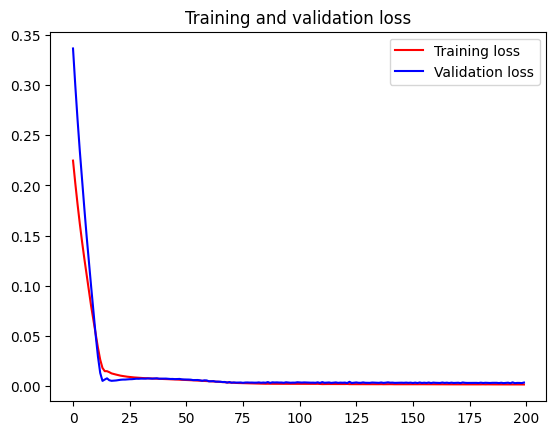

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


((214, 1), (138, 1))

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  2234.3970001873795
Train data MSE:  4992529.9544463605
Train data MAE:  1540.4418525481901
-------------------------------------------------------------------------------------
Test data RMSE:  3222.411878937541
Test data MSE:  10383938.317517774
Test data MAE:  2619.612049365941


In [ ]:
print("Train data explained variance regression score:",
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:",
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9829280350561804
Test data explained variance regression score: 0.8870211190250825


In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9827536598078128
Test data R2 score: 0.8331800882780037


In [ ]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.004273993985943193
Test data MGD:  0.006072666127539531
----------------------------------------------------------------------
Train data MPD:  131.28385387567909
Test data MPD:  248.1051207391666


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Value'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (384, 1)
Test predicted data:  (384, 1)


In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
predict = lstmdf[(len(lstmdf)-31):]
for day in predict:
  print(day)

46368.69000000001
50480.699930386545
50758.96347860098
51092.28353249788
51467.4588879323
51887.25081004143
52315.88706120014
52774.2347800231
53311.69099335909
53879.56571110725
54457.82941025972
55020.079682526586
55588.79838558197
56178.454293956755
56577.95235049009
56897.724051568504
57152.83373871326
57462.49672520637
57714.43111668587
57903.48701035261
58026.326683180334
58081.532876822945
58068.783921408656
57990.509857652185
57853.99762284756
57666.94499996662
57436.320441281794
57171.27083661318
56882.510022087095
56583.43984741211
56276.66870491505


# Simulation


## Simple Bitcoin Model

In [ ]:
# Starting price of bitcoin
file_path = "/content/drive/My Drive/csv's/BCHAIN-MKPRU.csv"
df = pd.read_csv(file_path)

starting_bc_price = df.iloc[0]['Value']
# Starting price of gold
#starting_gold_price = df.iloc[0]['USD (PM)']
# Represents how much of each vessel we own at the beginning
alloc = np.array([1000, 0, 0.0])
# How much a price must change to trigger buy or sell
threshold = 100
# How much money we move in and out of a vessel when buying or selling
unit = 0.05*alloc[0]

prev_price = starting_bc_price
# For every possible day to trade bitcoin
for index, row in df.iterrows():
    # Get the day's price
    curr_price = df.iloc[index]['Value']
    # Calculate our unit based on how much bitcoin we have
    unit = 0.05*alloc[0]
    enter_cash = unit
    # If bitcoin is in an upswing, sell
    if(curr_price - threshold >= prev_price):
        # Ensure we have enough bitcoin to sell
        num_bitcoin =  enter_cash / curr_price
        if(alloc[2]-num_bitcoin >= 0):
            # Cash moving out of bitcoin
            exit_cash = unit
            print(f"Selling {num_bitcoin} bitcoin for {exit_cash} dollars on day {index}")
            alloc[2] -= num_bitcoin
            alloc[0] +=  exit_cash #* 0.98
    # If bitcoin is in a downswing
    elif(curr_price + threshold <= prev_price):
        # Money needed to buy bitcoin
        # Ensure we have enough money to buy bitcoin
        if(alloc[0] - enter_cash > 0):
            num_bitcoin =  enter_cash / curr_price
            print(alloc[0], alloc[2])
            print(f"Buying {num_bitcoin} amount of bitcoin with {enter_cash} for {curr_price} dolallars on day {index}")
            alloc[2] +=  num_bitcoin
            alloc[0] -=  enter_cash #* 1.02
            print(alloc[0], alloc[2])
    else:
        continue

    prev_price = curr_price

print(f"Cash: {alloc[0]}")
print(f"Gold: {alloc[1]}")
print(f"Bitcoin: {alloc[2]}")
total_money = alloc[0] + alloc[2]*df.iloc[-1]['Value'] #+ alloc[1]*df.iloc[-1]['USD (PM)']
print(f"Total Money: {total_money}")
print(f"Total Gains {total_money-1000}")
print(f"Returns: {100*((total_money -1000)/ (1000))}%")

1000.0 0.0
Buying 0.050267928056541365 amount of bitcoin with 50.0 for 994.67 dolallars on day 116
950.0 0.050267928056541365
950.0 0.050267928056541365
Buying 0.06049260079977586 amount of bitcoin with 47.5 for 785.22 dolallars on day 122
902.5 0.11076052885631722
Selling 0.04992587183572313 bitcoin for 45.125 dollars on day 128
Selling 0.046771951784108416 bitcoin for 47.38125 dollars on day 145
995.00625 0.014062705236485673
Buying 0.0429847939330563 amount of bitcoin with 49.75031250000001 for 1157.3933 dolallars on day 178
945.2559375000001 0.05704749916954197
Selling 0.0375877294181633 bitcoin for 47.26279687500001 dollars on day 185
992.5187343750001 0.01945976975137867
Buying 0.04547948610526338 amount of bitcoin with 49.62593671875001 for 1091.171888 dolallars on day 187
942.8927976562501 0.06493925585664205
942.8927976562501 0.06493925585664205
Buying 0.049509596333229544 amount of bitcoin with 47.144639882812506 for 952.2323625 dolallars on day 188
895.7481577734376 0.114448

## LSTM for Bitcoin Data

In [ ]:
file_path = "/content/drive/My Drive/modelingComp/BCHAIN-MKPRU.csv"
df = pd.read_csv(file_path)

# Calculate price changes
df['Price_Change'] = df['Value'].diff()

# Invert the price changes
df['Inverted_Change'] = -df['Price_Change']

# Generate inverted prices with a lower bound of 0
df['Inverted_Price'] = df['Value'].iloc[0]  # Start with the initial price
for i in range(1, len(df)):
    # Calculate the new price, ensuring it doesn't go below zero
    new_price = df['Inverted_Price'].iloc[i-1] + df['Inverted_Change'].iloc[i]
    df.at[i, 'Inverted_Price'] = max(0, new_price)

# Drop unnecessary columns for clarity
df = df[['Date', 'Value', 'Inverted_Price']]
df.head()

inverted_df = df[['Date', 'Inverted_Price']]
inverted_df.head()
inverted_df = inverted_df.rename(columns={"Inverted_Price": "Value"})

inverted_df.head()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/modelingComp/BCHAIN-MKPRU.csv'

In [ ]:
# prompt: rename "Inverted_Price" column to "Value" in invert_df

invert_df = invert_df.rename(columns={"Inverted_Price": "Value"})
invert_df.head()
#min(invert_df)

NameError: name 'invert_df' is not defined

In [ ]:
# prompt: graph invert_df

import plotly.express as px

fig = px.line(inverted_df, x=inverted_df.Date, y=inverted_df.Value, labels={'date': 'Date', 'close': 'Inverted Price'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Inverted Bitcoin Price Over Time', plot_bgcolor='white',
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
from numpy import array
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

alloc = [1000, 0, 0]
buy_dates, sell_dates = [], []
buy_prices, sell_prices = [], []
predicted_prices = []

# Load the Bitcoin data
file_path = "/content/drive/My Drive/csv's/BCHAIN-MKPRU.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])

# Invert Bitcoin prices and shift up
inverted_df = df.copy()
inverted_df['Value'] = -inverted_df['Value']  # Make prices negative

# Find the minimum value of the inverted Bitcoin prices
min_value = inverted_df['Value'].min()

# Shift prices up so that the minimum value is 100
shift_amount = 100 - min_value
inverted_df['Value'] += shift_amount  # Shift all prices

for i, row in inverted_df.iterrows():
    cut_off_date = pd.to_datetime('9/11/17')
    if inverted_df.iloc[i]['Date'] < cut_off_date:
        continue
    else:
        if inverted_df.iloc[i]['Date'].day == 1:
            date = inverted_df.iloc[i]['Date']
            bc_price = inverted_df.iloc[i]['Value']
            unit = 0.05 * alloc[0]
            enter_cash = unit

            # Define a year ago date
            year_ago = inverted_df.iloc[i]['Date'].replace(year=inverted_df.iloc[i]['Date'].year - 1)
            print(year_ago)

            # Create a dataset of the last year
            temp_df = cut_df(inverted_df, year_ago, inverted_df.iloc[i]['Date'])
            close_stock = temp_df.copy()

            # Drop the Date column for scaling
            del temp_df['Date']
            scaler = MinMaxScaler(feature_range=(0, 1))
            temp_df = scaler.fit_transform(np.array(temp_df).reshape(-1, 1))

            # Split into training and testing data
            training_size = int(len(temp_df) * 0.60)
            test_size = len(temp_df) - training_size
            train_data, test_data = temp_df[0:training_size, :], temp_df[training_size:len(temp_df), :1]

            # Create datasets
            time_step = 15
            X_train, y_train = create_dataset(train_data, time_step)
            X_test, y_test = create_dataset(test_data, time_step)

            # Reshape for LSTM
            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

            # Define the LSTM model
            model = Sequential()
            model.add(LSTM(10, input_shape=(None, 1), activation="relu"))
            model.add(Dense(1))

            # Compile and train the model
            model.compile(loss="mean_squared_error", optimizer="adam")
            history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32, verbose=1)

            # Predictions
            train_predict = model.predict(X_train)
            test_predict = model.predict(X_test)

            # Inverse transform predictions
            train_predict = scaler.inverse_transform(train_predict)
            test_predict = scaler.inverse_transform(test_predict)
            original_ytrain = scaler.inverse_transform(y_train.reshape(-1, 1))
            original_ytest = scaler.inverse_transform(y_test.reshape(-1, 1))

            # Plot the predictions
            look_back = time_step
            trainPredictPlot = np.empty_like(temp_df)
            trainPredictPlot[:, :] = np.nan
            trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict
            print("Train predicted data: ", trainPredictPlot.shape)

            # Shift test predictions for plotting
            testPredictPlot = np.empty_like(temp_df)
            testPredictPlot[:, :] = np.nan
            testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(temp_df) - 1, :] = test_predict
            print("Test predicted data: ", testPredictPlot.shape)

            # Predict next 30 days
            x_input = test_data[len(test_data) - time_step:].reshape(1, -1)
            temp_input = list(x_input)
            temp_input = temp_input[0].tolist()

            lst_output = []
            n_steps = time_step
            i = 0
            pred_days = 30
            while i < pred_days:
                if len(temp_input) > time_step:
                    x_input = np.array(temp_input[1:])
                    x_input = x_input.reshape(1, -1)
                    x_input = x_input.reshape((1, n_steps, 1))

                    yhat = model.predict(x_input, verbose=0)
                    temp_input.extend(yhat[0].tolist())
                    temp_input = temp_input[1:]

                    lst_output.extend(yhat.tolist())
                    i += 1
                else:
                    x_input = x_input.reshape((1, n_steps, 1))
                    yhat = model.predict(x_input, verbose=0)
                    temp_input.extend(yhat[0].tolist())

                    lst_output.extend(yhat.tolist())
                    i += 1

            print("Output of predicted next days: ", len(lst_output))

            # Combine predictions with original data
            lstmdf = temp_df.tolist()
            lstmdf.extend((np.array(lst_output).reshape(-1, 1)).tolist())
            lstmdf = scaler.inverse_transform(lstmdf).reshape(1, -1).tolist()[0]

            predict = lstmdf[(len(lstmdf) - 31):]
            if predict[-1] > predict[0]:
                if alloc[0] - enter_cash >= 0:
                    print(f"Buying {enter_cash / bc_price} bitcoins on {date}")
                    print(f"Price = {bc_price}, unit = {enter_cash}")
                    alloc[0] -= 1.02 * enter_cash
                    alloc[2] += enter_cash / bc_price
                    buy_dates.append(date)
                    buy_prices.append(bc_price)
                    print(f"Cash: {alloc[0]}")
                    print(f"Bitcoin: {alloc[2]}")
            else:
                cash = bc_price * alloc[2]
                if alloc[2] - alloc[2] >= 0:
                    print(f"Selling {alloc[2]} bitcoins on {date}")
                    print(f"Price = {bc_price}, unit = {enter_cash}")
                    print("SELL")
                    sell_dates.append(date)
                    sell_prices.append(bc_price)
                    alloc[0] += 0.98 * cash
                    alloc[2] = 0
                    print(f"Cash: {alloc[0]}")
                    print(f"Bitcoin: {alloc[2]}")


FileNotFoundError: [Errno 2] No such file or directory: "/content/drive/My Drive/csv's/BCHAIN-MKPRU.csv"

In [ ]:
print(f"Cash: {alloc[0]}")
print(f"Gold: {alloc[1]}")
print(f"Bitcoin: {alloc[2]}")
total_money = alloc[0] + alloc[2]*df.iloc[-1]['Value'] #+ alloc[1]*df.iloc[-1]['USD (PM)']
print(f"Total Money: {total_money}")
print(f"Total Gains {total_money-1000}")
print(f"Returns: {100*((total_money -1000)/ (1000))}%")

Cash: 298.1252643464489
Gold: 0
Bitcoin: 0.11371333824037086
Total Money: 5570.863794079351
Total Gains 4570.863794079351
Returns: 457.08637940793506%


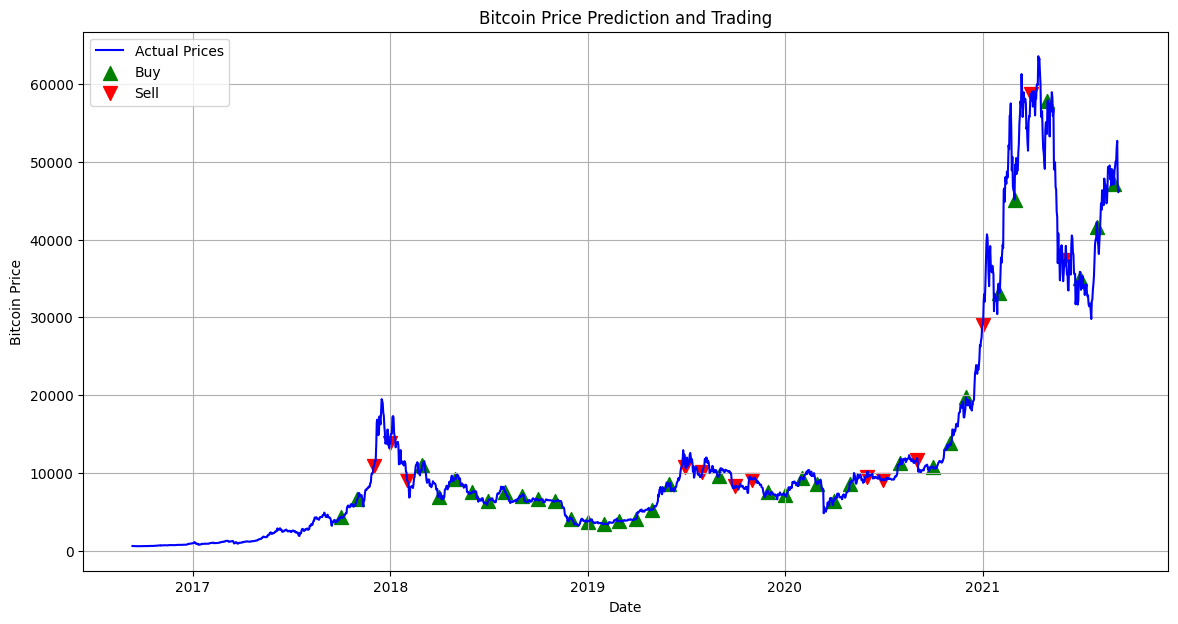

In [ ]:
# Plot predictions and actual prices
prediction_dates = df['Date'][-len(predicted_prices):]

# Plot actual and predicted prices
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Value'], label="Actual Prices", color="blue")
#plt.plot(prediction_dates, predicted_prices, label="Predicted Prices", color="orange")

# Mark buy and sell points
plt.scatter(buy_dates, buy_prices, marker="^", color="green", label="Buy", s=100)
plt.scatter(sell_dates, sell_prices, marker="v", color="red", label="Sell", s=100)

plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.title("Bitcoin Price Prediction and Trading")
plt.legend()
plt.grid()
plt.show()

## LSTM for Gold Data

In [ ]:
file_path = "/content/drive/My Drive/modelingComp/LBMA-GOLD.csv"
df = pd.read_csv(file_path)

,Date,USD (PM)
0,9/12/16,1324.60
1,9/13/16,1323.65
2,9/14/16,1321.75
3,9/15/16,1310.80
4,9/16/16,1308.35


In [ ]:
import pandas as pd

# Example DataFrame
file_path = "/content/drive/My Drive/modelingComp/LBMA-GOLD.csv"
df = pd.read_csv(file_path)

# Convert 'date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Generate a complete date range
start_date = df['Date'].min()
end_date = df['Date'].max()
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a new DataFrame with all dates
all_dates_df = pd.DataFrame({'Date': all_dates})

# Merge the original DataFrame with the new DataFrame
merged_df = pd.merge(all_dates_df, df, on='Date', how='left')

# Forward fill prices to propagate Friday's price to Saturday and Sunday
merged_df['USD (PM)'] = merged_df['USD (PM)'].fillna(method='ffill')
len(merged_df)

<ipython-input-14-d559ee71922d>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])
<ipython-input-14-d559ee71922d>:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['USD (PM)'] = merged_df['USD (PM)'].fillna(method='ffill')


1825

In [ ]:
from numpy import array
alloc = [1000, 0, 0]
buy_dates, sell_dates = [], []
buy_prices, sell_prices = [], []
predicted_prices = []

file_path = "/content/drive/My Drive/modelingComp/LBMA-GOLD.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])

prev_date = df.iloc[0]['Date']
cut_off_date = pd.to_datetime('9/11/17')

df = merged_df

for i, row in df.iterrows():

  date = df.iloc[i]['Date']

  if date < cut_off_date:
    prev_date = date
    continue
  else:
    if(date.day < prev_date.day):

      price = df.iloc[i]['USD (PM)']
      unit = 0.05*alloc[0]
      enter_cash = unit

      year_ago = df.iloc[i]['Date'].replace(year=df.iloc[i]['Date'].year - 1)
      print(year_ago)
      temp_df = cut_df(df,year_ago, df.iloc[i]['Date'])
      close_stock = temp_df.copy()

      del temp_df['Date']
      scaler=MinMaxScaler(feature_range=(0,1))
      temp_df=scaler.fit_transform(np.array(temp_df).reshape(-1,1))

      training_size=int(len(temp_df)*0.60)
      test_size=len(temp_df)-training_size
      train_data,test_data=temp_df[0:training_size,:],temp_df[training_size:len(temp_df),:1]

      time_step = 15
      X_train, y_train = create_dataset(train_data, time_step)
      X_test, y_test = create_dataset(test_data, time_step)

      X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
      X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

      model=Sequential()

      model.add(LSTM(10,input_shape=(None,1),activation="relu"))

      model.add(Dense(1))

      model.compile(loss="mean_squared_error",optimizer="adam")

      history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

      train_predict=model.predict(X_train)
      test_predict=model.predict(X_test)

      train_predict = scaler.inverse_transform(train_predict)
      test_predict = scaler.inverse_transform(test_predict)
      original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
      original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))


      look_back=time_step
      trainPredictPlot = np.empty_like(temp_df)
      trainPredictPlot[:, :] = np.nan
      trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
      print("Train predicted data: ", trainPredictPlot.shape)

      # shift test predictions for plotting
      testPredictPlot = np.empty_like(temp_df)
      testPredictPlot[:, :] = np.nan
      testPredictPlot[len(train_predict)+(look_back*2)+1:len(temp_df)-1, :] = test_predict
      print("Test predicted data: ", testPredictPlot.shape)

      x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
      temp_input=list(x_input)
      temp_input=temp_input[0].tolist()

      lst_output=[]
      n_steps=time_step
      i=0
      pred_days = 30
      while(i<pred_days):

          if(len(temp_input)>time_step):

              x_input=np.array(temp_input[1:])
              #print("{} day input {}".format(i,x_input))
              x_input = x_input.reshape(1,-1)
              x_input = x_input.reshape((1, n_steps, 1))

              yhat = model.predict(x_input, verbose=0)
              #print("{} day output {}".format(i,yhat))
              temp_input.extend(yhat[0].tolist())
              temp_input=temp_input[1:]
              #print(temp_input)

              lst_output.extend(yhat.tolist())
              i=i+1

          else:

              x_input = x_input.reshape((1, n_steps,1))
              yhat = model.predict(x_input, verbose=0)
              temp_input.extend(yhat[0].tolist())

              lst_output.extend(yhat.tolist())
              i=i+1

      print("Output of predicted next days: ", len(lst_output))

      lstmdf=temp_df.tolist()
      lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
      lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

      predict = lstmdf[(len(lstmdf)-31):]
      if predict[-1] > predict[0]:
        print(f"\t\t\t First: {predict[0]}, Last: {predict[-1]}")
        #print(f"\t\t\t Price: {price}, unit: {enter_cash
        if alloc[0] - enter_cash >= 0:
          print(f"\t\t Buying {enter_cash / price} units of gold on {date}")
          print(f"\t\t Price: {price}, unit: {enter_cash}")
          alloc[0] -= 1.01 * enter_cash
          alloc[2] += enter_cash / price
          buy_dates.append(date)
          buy_prices.append(price)
      else:
        if alloc[2] - (enter_cash / price) >= 0:
          print(f"\t\t Selling {enter_cash / price} units of gold on {date}")
          print(f"\t\t Price: {price}, unit: {enter_cash}")
          sell = enter_cash / price
          #print("SELL")
          sell_dates.append(date)
          sell_prices.append(price)
          alloc[0] += 0.99 * enter_cash
          alloc[2] -= sell

    prev_date = date

<ipython-input-22-7285119aedb8>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2016-10-01 00:00:00
Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.2539 - val_loss: 0.4705
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2317 - val_loss: 0.4343
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1919 - val_loss: 0.4032
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1863 - val_loss: 0.3750
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1930 - val_loss: 0.3475
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1570 - val_loss: 0.3218
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1426 - val_loss: 0.2957
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1230 - val_loss: 0.2685
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1062 - val_loss: 0.2405
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0905 - val_loss: 0.2117
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0932 - val_loss: 0.1816
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.1366 - val_loss: 0.2800
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1155 - val_loss: 0.2323
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0889 - val_loss: 0.1755
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0639 - val_loss: 0.1175
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0406 - val_loss: 0.0629
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0205 - val_loss: 0.0203
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0095 - val_loss: 0.0040
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0087 - val_loss: 0.0043
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0085 - val_loss: 0.0043
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0066 - val_loss: 0.0070
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0069 - val_loss: 0.0045
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.3484 - val_loss: 0.6972
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3167 - val_loss: 0.6526
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2845 - val_loss: 0.6133
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2610 - val_loss: 0.5788
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2517 - val_loss: 0.5433
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2225 - val_loss: 0.5008
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2048 - val_loss: 0.4582
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1678 - val_loss: 0.4050
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1402 - val_loss: 0.3245
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1015 - val_loss: 0.2371
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0632 - val_loss: 0.1499
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0388 - val_loss: 0.0775
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.2832 - val_loss: 0.5138
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2460 - val_loss: 0.4618
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2175 - val_loss: 0.4141
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1864 - val_loss: 0.3702
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1752 - val_loss: 0.3290
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1501 - val_loss: 0.2908
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1273 - val_loss: 0.2546
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1064 - val_loss: 0.2200
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0920 - val_loss: 0.1871
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0729 - val_loss: 0.1546
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0578 - val_loss: 0.1201
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0395 - val_loss: 0.0731
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.1575 - val_loss: 0.3505
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1502 - val_loss: 0.3140
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1223 - val_loss: 0.2782
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1168 - val_loss: 0.2408
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0943 - val_loss: 0.1993
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0762 - val_loss: 0.1535
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0545 - val_loss: 0.1026
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0384 - val_loss: 0.0497
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0194 - val_loss: 0.0117
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0119 - val_loss: 0.0132
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0124 - val_loss: 0.0110
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0120 - val_loss: 0.0078
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.1993 - val_loss: 0.4309
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2056 - val_loss: 0.4094
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1930 - val_loss: 0.3872
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1841 - val_loss: 0.3636
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1528 - val_loss: 0.3390
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1399 - val_loss: 0.3122
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1361 - val_loss: 0.2822
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1182 - val_loss: 0.2490
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1050 - val_loss: 0.2107
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0813 - val_loss: 0.1642
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0535 - val_loss: 0.1066
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0293 - val_loss: 0.0440
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.1904 - val_loss: 0.4069
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1570 - val_loss: 0.3552
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1383 - val_loss: 0.3063
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1199 - val_loss: 0.2604
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0980 - val_loss: 0.2172
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0851 - val_loss: 0.1745
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0647 - val_loss: 0.1332
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0543 - val_loss: 0.0938
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0334 - val_loss: 0.0589
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0208 - val_loss: 0.0304
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0154 - val_loss: 0.0139
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0099 - val_loss: 0.0094
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.2571 - val_loss: 0.6802
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2234 - val_loss: 0.5875
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1709 - val_loss: 0.5042
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1482 - val_loss: 0.4274
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1292 - val_loss: 0.3570
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1030 - val_loss: 0.2945
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0898 - val_loss: 0.2366
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0687 - val_loss: 0.1790
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0503 - val_loss: 0.1197
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0318 - val_loss: 0.0641
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0161 - val_loss: 0.0235
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0101 - val_loss: 0.0091
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.2062 - val_loss: 0.4673
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1686 - val_loss: 0.3895
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1462 - val_loss: 0.3190
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1142 - val_loss: 0.2579
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0882 - val_loss: 0.2047
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0808 - val_loss: 0.1556
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0543 - val_loss: 0.1113
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0426 - val_loss: 0.0711
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0265 - val_loss: 0.0380
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0231 - val_loss: 0.0158
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0117 - val_loss: 0.0070
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0084 - val_loss: 0.0069
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.3707 - val_loss: 0.5218
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3181 - val_loss: 0.4775
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2953 - val_loss: 0.4333
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2644 - val_loss: 0.3883
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2281 - val_loss: 0.3419
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2097 - val_loss: 0.2923
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1707 - val_loss: 0.2389
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1277 - val_loss: 0.1753
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1005 - val_loss: 0.1029
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0603 - val_loss: 0.0365
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0235 - val_loss: 0.0115
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0216 - val_loss: 0.0107
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.6265 - val_loss: 0.5478
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5932 - val_loss: 0.5093
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5154 - val_loss: 0.4756
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4973 - val_loss: 0.4481
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4810 - val_loss: 0.4218
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4390 - val_loss: 0.3967
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3958 - val_loss: 0.3722
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3811 - val_loss: 0.3479
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3917 - val_loss: 0.3236
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3314 - val_loss: 0.2996
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3135 - val_loss: 0.2751
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2981 - val_loss: 0.2500
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.8376 - val_loss: 0.4197
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7831 - val_loss: 0.3776
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7152 - val_loss: 0.3405
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6464 - val_loss: 0.3078
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5796 - val_loss: 0.2784
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5367 - val_loss: 0.2516
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5022 - val_loss: 0.2269
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4439 - val_loss: 0.2043
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4094 - val_loss: 0.1832
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3634 - val_loss: 0.1633
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3300 - val_loss: 0.1443
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2848 - val_loss: 0.1263
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 1.0240 - val_loss: 0.2381
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8716 - val_loss: 0.2017
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7591 - val_loss: 0.1696
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6761 - val_loss: 0.1412
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5826 - val_loss: 0.1163
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4656 - val_loss: 0.0927
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3849 - val_loss: 0.0707
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3149 - val_loss: 0.0512
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2179 - val_loss: 0.0353
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1467 - val_loss: 0.0244
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0767 - val_loss: 0.0209
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0284 - val_loss: 0.0260
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.5992 - val_loss: 0.0562
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5243 - val_loss: 0.0478
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4898 - val_loss: 0.0406
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4490 - val_loss: 0.0342
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4188 - val_loss: 0.0286
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3765 - val_loss: 0.0236
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3304 - val_loss: 0.0193
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2933 - val_loss: 0.0156
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2505 - val_loss: 0.0126
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2168 - val_loss: 0.0103
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1805 - val_loss: 0.0087
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1467 - val_loss: 0.0080
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.4779 - val_loss: 0.0205
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3493 - val_loss: 0.0122
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2597 - val_loss: 0.0073
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1683 - val_loss: 0.0045
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1220 - val_loss: 0.0033
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0760 - val_loss: 0.0035
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0419 - val_loss: 0.0048
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0198 - val_loss: 0.0070
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0071 - val_loss: 0.0094
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0037 - val_loss: 0.0112
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0042 - val_loss: 0.0119
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0042 - val_loss: 0.0118
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.5815 - val_loss: 0.0688
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5655 - val_loss: 0.0617
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5471 - val_loss: 0.0554
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4840 - val_loss: 0.0496
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4710 - val_loss: 0.0444
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4131 - val_loss: 0.0396
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4107 - val_loss: 0.0350
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3882 - val_loss: 0.0306
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3446 - val_loss: 0.0263
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3219 - val_loss: 0.0222
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2853 - val_loss: 0.0182
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2477 - val_loss: 0.0146
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.4349 - val_loss: 0.1274
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3487 - val_loss: 0.0914
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2432 - val_loss: 0.0580
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1744 - val_loss: 0.0304
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0830 - val_loss: 0.0138
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0313 - val_loss: 0.0138
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0162 - val_loss: 0.0211
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0223 - val_loss: 0.0165
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0157 - val_loss: 0.0119
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0153 - val_loss: 0.0105
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0121 - val_loss: 0.0101
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0125 - val_loss: 0.0101
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.2098 - val_loss: 0.1818
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1897 - val_loss: 0.1480
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1451 - val_loss: 0.1149
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1213 - val_loss: 0.0836
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0965 - val_loss: 0.0548
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0623 - val_loss: 0.0311
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0290 - val_loss: 0.0147
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0163 - val_loss: 0.0074
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0133 - val_loss: 0.0067
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0140 - val_loss: 0.0062
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0113 - val_loss: 0.0063
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0105 - val_loss: 0.0070
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.1520 - val_loss: 0.2725
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1496 - val_loss: 0.2468
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1360 - val_loss: 0.2188
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1021 - val_loss: 0.1886
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0921 - val_loss: 0.1543
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0742 - val_loss: 0.1172
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0537 - val_loss: 0.0775
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0291 - val_loss: 0.0389
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0131 - val_loss: 0.0117
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0052 - val_loss: 0.0045
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0045 - val_loss: 0.0067
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0032 - val_loss: 0.0099
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.1864 - val_loss: 0.6365
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1652 - val_loss: 0.5447
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1352 - val_loss: 0.4566
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1100 - val_loss: 0.3726
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0830 - val_loss: 0.2935
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0656 - val_loss: 0.2203
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0453 - val_loss: 0.1520
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0300 - val_loss: 0.0931
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0187 - val_loss: 0.0454
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0090 - val_loss: 0.0186
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0065 - val_loss: 0.0099
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0059 - val_loss: 0.0085
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.1130 - val_loss: 0.5424
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1046 - val_loss: 0.5234
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1009 - val_loss: 0.5048
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1016 - val_loss: 0.4871
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0937 - val_loss: 0.4704
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0821 - val_loss: 0.4557
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0728 - val_loss: 0.4410
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0632 - val_loss: 0.4148
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0581 - val_loss: 0.3794
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0490 - val_loss: 0.3369
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0344 - val_loss: 0.2793
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0291 - val_loss: 0.2139
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0522 - val_loss: 0.2215
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0426 - val_loss: 0.1881
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0282 - val_loss: 0.1558
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0261 - val_loss: 0.1246
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0195 - val_loss: 0.0949
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0146 - val_loss: 0.0676
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0097 - val_loss: 0.0432
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0076 - val_loss: 0.0249
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0053 - val_loss: 0.0148
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0048 - val_loss: 0.0103
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0042 - val_loss: 0.0074
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0032 - val_loss: 0.0052
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0965 - val_loss: 0.3347
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0720 - val_loss: 0.2867
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0629 - val_loss: 0.2399
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0482 - val_loss: 0.1949
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0348 - val_loss: 0.1488
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0245 - val_loss: 0.0995
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0173 - val_loss: 0.0501
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0099 - val_loss: 0.0128
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0056 - val_loss: 0.0072
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0043 - val_loss: 0.0112
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0038 - val_loss: 0.0089
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0030 - val_loss: 0.0142
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.1299 - val_loss: 0.6725
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1072 - val_loss: 0.5871
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0805 - val_loss: 0.5205
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0710 - val_loss: 0.4667
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0618 - val_loss: 0.4192
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0484 - val_loss: 0.3777
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0393 - val_loss: 0.3398
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0336 - val_loss: 0.3040
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0266 - val_loss: 0.2702
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0187 - val_loss: 0.2325
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0143 - val_loss: 0.1936
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0122 - val_loss: 0.1599
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0642 - val_loss: 0.4238
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0435 - val_loss: 0.3293
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0310 - val_loss: 0.2486
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0213 - val_loss: 0.1773
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0121 - val_loss: 0.1178
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0062 - val_loss: 0.0712
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0037 - val_loss: 0.0397
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0025 - val_loss: 0.0232
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0029 - val_loss: 0.0184
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0026 - val_loss: 0.0192
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0022 - val_loss: 0.0213
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0023 - val_loss: 0.0231
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0827 - val_loss: 0.7220
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0709 - val_loss: 0.6584
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0636 - val_loss: 0.5977
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0516 - val_loss: 0.5400
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0447 - val_loss: 0.4842
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0365 - val_loss: 0.4303
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0306 - val_loss: 0.3790
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0210 - val_loss: 0.3315
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0143 - val_loss: 0.2853
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0109 - val_loss: 0.2366
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0069 - val_loss: 0.1814
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0048 - val_loss: 0.1381
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0900 - val_loss: 0.7144
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0768 - val_loss: 0.6738
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0695 - val_loss: 0.6380
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0648 - val_loss: 0.6061
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0567 - val_loss: 0.5760
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0558 - val_loss: 0.5470
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0503 - val_loss: 0.5198
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0455 - val_loss: 0.4933
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0405 - val_loss: 0.4672
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0356 - val_loss: 0.4411
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0334 - val_loss: 0.4138
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0301 - val_loss: 0.3853
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0657 - val_loss: 0.4425
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0549 - val_loss: 0.3714
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0477 - val_loss: 0.2979
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0344 - val_loss: 0.2222
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0225 - val_loss: 0.1440
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0195 - val_loss: 0.0650
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0108 - val_loss: 0.0123
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0072 - val_loss: 0.0107
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0060 - val_loss: 0.0465
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0057 - val_loss: 0.0499
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0047 - val_loss: 0.0517
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0041 - val_loss: 0.1273
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.1100 - val_loss: 0.3560
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0968 - val_loss: 0.2931
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0919 - val_loss: 0.2202
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0558 - val_loss: 0.1364
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0393 - val_loss: 0.0487
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0193 - val_loss: 0.0058
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0095 - val_loss: 0.0394
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0081 - val_loss: 0.0180
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0046 - val_loss: 0.0076
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0048 - val_loss: 0.0093
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0037 - val_loss: 0.0193
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0052 - val_loss: 0.0242
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.1600 - val_loss: 0.4463
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1382 - val_loss: 0.4280
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1390 - val_loss: 0.4108
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1332 - val_loss: 0.3945
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1204 - val_loss: 0.3787
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1220 - val_loss: 0.3631
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1124 - val_loss: 0.3477
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1072 - val_loss: 0.3324
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1073 - val_loss: 0.3175
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1022 - val_loss: 0.3024
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0908 - val_loss: 0.2876
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0907 - val_loss: 0.2721
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.1965 - val_loss: 0.4809
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1515 - val_loss: 0.3961
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1345 - val_loss: 0.3164
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0986 - val_loss: 0.2428
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0664 - val_loss: 0.1747
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0473 - val_loss: 0.1136
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0254 - val_loss: 0.0644
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0108 - val_loss: 0.0297
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0040 - val_loss: 0.0113
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013 - val_loss: 0.0059
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0013 - val_loss: 0.0050
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0014 - val_loss: 0.0052
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.1586 - val_loss: 0.4654
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1420 - val_loss: 0.4280
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1236 - val_loss: 0.3941
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1125 - val_loss: 0.3610
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0980 - val_loss: 0.3138
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0725 - val_loss: 0.2535
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0503 - val_loss: 0.1889
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0328 - val_loss: 0.1242
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0170 - val_loss: 0.0686
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0094 - val_loss: 0.0351
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0081 - val_loss: 0.0253
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0068 - val_loss: 0.0234
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.1294 - val_loss: 0.4379
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1042 - val_loss: 0.3589
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0828 - val_loss: 0.2892
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0588 - val_loss: 0.2302
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0409 - val_loss: 0.1745
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0261 - val_loss: 0.1231
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0154 - val_loss: 0.0786
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0073 - val_loss: 0.0436
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0029 - val_loss: 0.0223
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0020 - val_loss: 0.0137
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0026 - val_loss: 0.0126
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0023 - val_loss: 0.0150
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.1222 - val_loss: 0.7443
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0984 - val_loss: 0.6717
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0858 - val_loss: 0.6056
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0693 - val_loss: 0.5435
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0582 - val_loss: 0.4861
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0518 - val_loss: 0.4311
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0407 - val_loss: 0.3788
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0309 - val_loss: 0.3289
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0276 - val_loss: 0.2787
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0230 - val_loss: 0.2295
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0158 - val_loss: 0.1827
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0127 - val_loss: 0.1399
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0811 - val_loss: 0.4571
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0502 - val_loss: 0.3748
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0384 - val_loss: 0.3097
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0318 - val_loss: 0.2584
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0208 - val_loss: 0.2173
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0131 - val_loss: 0.1815
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0113 - val_loss: 0.1506
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0080 - val_loss: 0.1251
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0060 - val_loss: 0.1045
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0057 - val_loss: 0.0894
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0043 - val_loss: 0.0807
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0046 - val_loss: 0.0747
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0290 - val_loss: 0.3738
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0228 - val_loss: 0.3523
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0228 - val_loss: 0.3332
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0188 - val_loss: 0.3164
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0161 - val_loss: 0.3008
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0143 - val_loss: 0.2862
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0140 - val_loss: 0.2720
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0150 - val_loss: 0.2582
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0101 - val_loss: 0.2452
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0109 - val_loss: 0.2318
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0095 - val_loss: 0.2191
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0082 - val_loss: 0.2059
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0409 - val_loss: 0.3923
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0382 - val_loss: 0.3534
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0293 - val_loss: 0.3133
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0227 - val_loss: 0.2714
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0192 - val_loss: 0.2279
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0157 - val_loss: 0.1798
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0133 - val_loss: 0.1459
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0135 - val_loss: 0.1313
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0124 - val_loss: 0.1205
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0113 - val_loss: 0.1099
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0107 - val_loss: 0.0963
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0098 - val_loss: 0.0805
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0467 - val_loss: 0.2798
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0386 - val_loss: 0.2409
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0313 - val_loss: 0.2020
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0216 - val_loss: 0.1562
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0156 - val_loss: 0.1132
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0114 - val_loss: 0.0757
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0076 - val_loss: 0.0469
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0065 - val_loss: 0.0276
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0062 - val_loss: 0.0182
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0062 - val_loss: 0.0163
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0060 - val_loss: 0.0166
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0053 - val_loss: 0.0150
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0653 - val_loss: 0.3278
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0578 - val_loss: 0.2899
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0465 - val_loss: 0.2502
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0352 - val_loss: 0.2084
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0285 - val_loss: 0.1625
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0170 - val_loss: 0.1112
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0102 - val_loss: 0.0645
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0062 - val_loss: 0.0299
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0037 - val_loss: 0.0151
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0030 - val_loss: 0.0099
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0031 - val_loss: 0.0068
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0025 - val_loss: 0.0044
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.2127 - val_loss: 0.5817
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1899 - val_loss: 0.5006
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1425 - val_loss: 0.4314
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1328 - val_loss: 0.3690
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1069 - val_loss: 0.3109
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0829 - val_loss: 0.2543
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0719 - val_loss: 0.2017
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0498 - val_loss: 0.1569
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0431 - val_loss: 0.1164
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0308 - val_loss: 0.0760
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0183 - val_loss: 0.0400
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0127 - val_loss: 0.0141
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.3112 - val_loss: 0.4725
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2643 - val_loss: 0.4201
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2449 - val_loss: 0.3706
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1979 - val_loss: 0.3241
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1776 - val_loss: 0.2789
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1464 - val_loss: 0.2344
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1258 - val_loss: 0.1897
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0999 - val_loss: 0.1438
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0742 - val_loss: 0.0988
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0510 - val_loss: 0.0572
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0278 - val_loss: 0.0222
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0126 - val_loss: 0.0037
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.2851 - val_loss: 0.3391
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2872 - val_loss: 0.2836
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2175 - val_loss: 0.2295
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1810 - val_loss: 0.1764
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1309 - val_loss: 0.1260
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0900 - val_loss: 0.0801
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0631 - val_loss: 0.0409
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0320 - val_loss: 0.0125
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0116 - val_loss: 0.0023
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0066 - val_loss: 0.0042
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0080 - val_loss: 0.0028
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0064 - val_loss: 0.0024
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.1159 - val_loss: 0.0725
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0903 - val_loss: 0.0476
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0585 - val_loss: 0.0256
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0309 - val_loss: 0.0098
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0117 - val_loss: 0.0029
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0031 - val_loss: 0.0027
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.1463 - val_loss: 0.0427
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1034 - val_loss: 0.0269
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0689 - val_loss: 0.0146
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0392 - val_loss: 0.0072
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0165 - val_loss: 0.0073
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0088 - val_loss: 0.0120
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0098 - val_loss: 0.0115
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0100 - val_loss: 0.0087
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0083 - val_loss: 0.0073
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0081 - val_loss: 0.0071
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0083 - val_loss: 0.0073
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0080 - val_loss: 0.0075
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0939 - val_loss: 0.0193
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0643 - val_loss: 0.0093
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0306 - val_loss: 0.0049
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0130 - val_loss: 0.0068
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0060 - val_loss: 0.0111
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0066 - val_loss: 0.0110
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0065 - val_loss: 0.0082
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0050 - val_loss: 0.0067
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0048 - val_loss: 0.0064
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0051 - val_loss: 0.0067
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0047 - val_loss: 0.0071
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0046 - val_loss: 0.0072
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.6339 - val_loss: 0.1721
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5540 - val_loss: 0.1429
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4827 - val_loss: 0.1193
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3929 - val_loss: 0.1000
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3432 - val_loss: 0.0836
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3003 - val_loss: 0.0695
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2427 - val_loss: 0.0572
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2078 - val_loss: 0.0459
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1709 - val_loss: 0.0354
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1307 - val_loss: 0.0264
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0943 - val_loss: 0.0187
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0576 - val_loss: 0.0132
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.3081 - val_loss: 0.0976
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1964 - val_loss: 0.0550
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1156 - val_loss: 0.0247
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0485 - val_loss: 0.0092
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0137 - val_loss: 0.0082
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0078 - val_loss: 0.0117
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0127 - val_loss: 0.0092
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0082 - val_loss: 0.0061
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0068 - val_loss: 0.0056
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0074 - val_loss: 0.0057
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0069 - val_loss: 0.0060
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0072 - val_loss: 0.0060
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.3962 - val_loss: 0.2468
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3475 - val_loss: 0.2213
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3302 - val_loss: 0.1981
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2952 - val_loss: 0.1766
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2717 - val_loss: 0.1560
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2356 - val_loss: 0.1357
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1941 - val_loss: 0.1141
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1586 - val_loss: 0.0853
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1061 - val_loss: 0.0494
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0535 - val_loss: 0.0207
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0199 - val_loss: 0.0159
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0236 - val_loss: 0.0148
E

In [ ]:
print(f"Cash: {alloc[0]}")
#print(f"Gold: {alloc[1]}")
print(f"Gold: {alloc[2]}")
total_money = alloc[0] + alloc[1]*df.iloc[-1]['USD (PM)'] #alloc[2]*df.iloc[-1]['Value']
print(f"Total Money: {total_money}")
print(f"Total Gains {total_money-1000}")
print(f"Returns: {100*((total_money -1000)/ (1000))}%")

Cash: 516.6437271840343
Gold: 0
Bitcoin: 0.27673403487502124
Total Money: 516.6437271840343
Total Gains -483.35627281596567
Returns: -48.335627281596565%


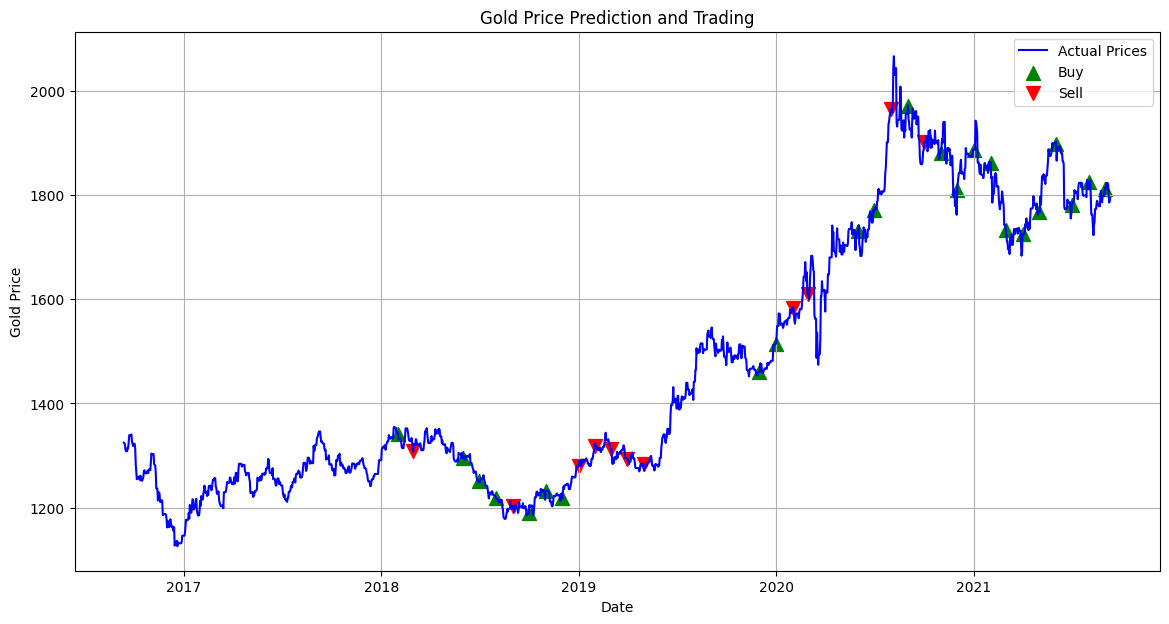

In [ ]:
# Plot predictions and actual prices
prediction_dates = df['Date'][-len(predicted_prices):]

# Plot actual and predicted prices
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['USD (PM)'], label="Actual Prices", color="blue")
#plt.plot(prediction_dates, predicted_prices, label="Predicted Prices", color="orange")

# Mark buy and sell points
plt.scatter(buy_dates, buy_prices, marker="^", color="green", label="Buy", s=100)
plt.scatter(sell_dates, sell_prices, marker="v", color="red", label="Sell", s=100)

plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.title("Gold Price Prediction and Trading")
plt.legend()
plt.grid()
plt.show()